In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
import warnings; warnings.simplefilter('ignore')

## Data Preprocessing and Visualization

In [2]:
df= pd. read_csv('C:/Users/Rohan Sharma/Desktop/movies_metadata.csv')
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
df.shape

(45466, 24)

In [4]:
df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [5]:
df.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [6]:
df.drop(['belongs_to_collection', 'homepage','tagline'], axis='columns', inplace=True)

In [7]:
df.dropna(subset=['overview','release_date','title','video','imdb_id'],inplace=True)

In [8]:
df['original_language'] = df['original_language'].fillna(method='bfill')
df['poster_path'] = df['poster_path'].fillna(method='bfill')
df['status'] = df['status'].fillna(method='bfill')

In [9]:
df.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
poster_path             0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [10]:
df.shape

(44423, 21)

In [11]:
df['original_language'].drop_duplicates().shape[0]

89

In [12]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,32131,en
fr,2278,fr
ja,1345,ja
it,1264,it
de,962,de


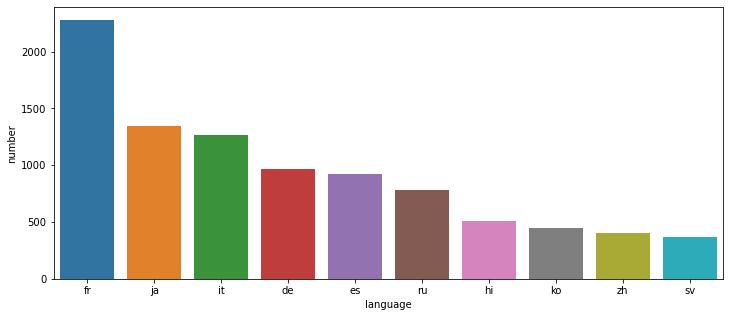

In [13]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

In [14]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [15]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [16]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [17]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

<AxesSubplot:title={'center':'Number of Movies released in a particular month.'}, xlabel='month', ylabel='count'>

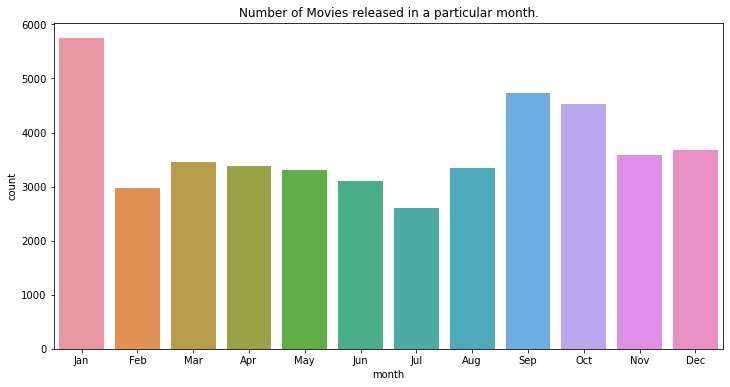

In [18]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order)

<AxesSubplot:title={'center':'Average Gross by the Month for Blockbuster Movies'}, xlabel='mon', ylabel='revenue'>

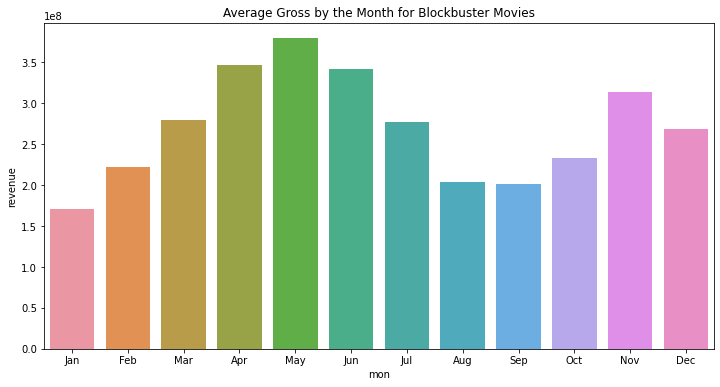

In [19]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

In [20]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

<AxesSubplot:ylabel='Frequency'>

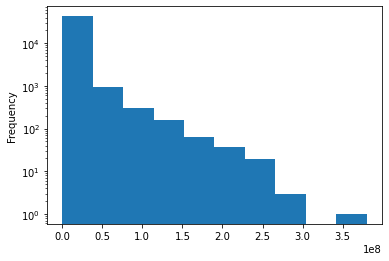

In [21]:
df['budget'].plot(logy=True, kind='hist')

## Weighted Average

In [22]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.267834230015983

In [23]:
m = vote_counts.quantile(0.95)
m

447.0

In [24]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [25]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2225, 6)

In [26]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [27]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [28]:
qualified = qualified.sort_values('wr', ascending=False).head()

In [29]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",7.915902
12481,The Dark Knight,2008,12269,8,123.167,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",7.903957
22879,Interstellar,2014,11187,8,32.2135,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",7.895025
2843,Fight Club,1999,9678,8,63.8696,"[{'id': 18, 'name': 'Drama'}]",7.879380
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.869228


## Content Based Recommendation

In [30]:
movie_data=pd.read_csv('C:/Users/Rohan Sharma/Desktop/ml-latest-small/ratings.csv')
movie_data.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [31]:
movies=pd.read_csv('C:/Users/Rohan Sharma/Desktop/ml-latest-small/movies.csv')
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [32]:
tags=pd.read_csv('C:/Users/Rohan Sharma/Desktop/ml-latest-small/tags.csv')
tags=tags[['movieId','tag']]
tags.head(10)

,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA
5,89774,Tom Hardy
6,106782,drugs
7,106782,Leonardo DiCaprio
8,106782,Martin Scorsese
9,48516,way too long


In [33]:
movie_data=movie_data.merge(movies,on='movieId',how='left')
movie_data=movie_data.merge(tags,on='movieId',how='left')
movie_data.head(10)

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
5,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN
6,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,mystery
7,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,twist ending
8,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,serial killer
9,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,mindfuck


In [34]:
rating = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
rating.head(10)

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
'Tis the Season for Love (2015),1.500000
"'burbs, The (1989)",3.176471
'night Mother (1986),3.000000
(500) Days of Summer (2009),3.666667


In [35]:
rating['Total Rating']=pd.DataFrame(movie_data.groupby('title')['rating'].count())
rating.head(10)

,rating,Total Rating
title,,
'71 (2014),4.000000,1
'Hellboy': The Seeds of Creation (2004),4.000000,1
'Round Midnight (1986),3.500000,2
'Salem's Lot (2004),5.000000,1
'Til There Was You (1997),4.000000,2
'Tis the Season for Love (2015),1.500000,1
"'burbs, The (1989)",3.176471,17
'night Mother (1986),3.000000,1
(500) Days of Summer (2009),3.666667,336


In [36]:
movie_user=movie_data.pivot_table(index='userId',columns='title',values='rating')

In [37]:
correlation=movie_user.corrwith(movie_user['Iron Man (2008)'])
correlation.head(10)

title
'71 (2014)                                      NaN
'Hellboy': The Seeds of Creation (2004)         NaN
'Round Midnight (1986)                          NaN
'Salem's Lot (2004)                             NaN
'Til There Was You (1997)                       NaN
'Tis the Season for Love (2015)                 NaN
'burbs, The (1989)                         0.456543
'night Mother (1986)                            NaN
(500) Days of Summer (2009)                0.611279
*batteries not included (1987)             0.271448
dtype: float64

In [38]:
recommandation=pd.DataFrame(correlation,columns=['correlation'])
recommandation.dropna(inplace=True)
recommandation=recommandation.join(rating['Total Rating'])
recommandation.head()

,correlation,Total Rating
title,,
"'burbs, The (1989)",0.456543,17
(500) Days of Summer (2009),0.611279,336
*batteries not included (1987),0.271448,7
10 Cloverfield Lane (2016),-0.206733,28
10 Things I Hate About You (1999),-0.264545,54


In [39]:
recc=recommandation[recommandation['Total Rating']>150].sort_values('correlation',ascending=False).reset_index()
recc=recc.merge(movies,on='title',how='left')
recc.head(10)

,title,correlation,Total Rating,movieId,genres
0,Avengers: Infinity War - Part I (2018),0.764922,195,122912,Action|Adventure|Sci-Fi
1,Whiplash (2014),0.711657,342,112552,Drama
2,Star Trek (2009),0.687861,531,68358,Action|Adventure|Sci-Fi|IMAX
3,"Avengers, The (2012)",0.684344,483,89745,Action|Adventure|Sci-Fi|IMAX
4,Ratatouille (2007),0.657183,288,50872,Animation|Children|Drama
5,Terminator Salvation (2009),0.619493,216,68791,Action|Adventure|Sci-Fi|Thriller
6,(500) Days of Summer (2009),0.611279,336,69757,Comedy|Drama|Romance
7,X2: X-Men United (2003),0.609979,380,6333,Action|Adventure|Sci-Fi|Thriller
8,X-Men (2000),0.583925,798,3793,Action|Adventure|Sci-Fi
9,Burn After Reading (2008),0.564151,429,61323,Comedy|Crime|Drama


# Collaborative Filtering

### K Means

In [40]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
#load the movielens-100k dataset  UserId :: MovieID :: Rating ::Timestamp
data=Dataset.load_builtin('ml-100k')

In [41]:
trainset,testset=train_test_split(data,test_size=.20)
algo=KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based':True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [42]:
#We can now query for speicific predictions
uid=str(196)
lid=str(302) 
# get a prediction for specific users and items
pred=algo.predict(uid,lid,verbose=True) 

user: 196        item: 302        r_ui = None   est = 4.00   {'actual_k': 50, 'was_impossible': False}


In [43]:
#run the trained model against the tesset
test_pred=algo.test(testset)
test_pred

[Prediction(uid='736', iid='246', r_ui=4.0, est=3.458560613061867, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='666', iid='405', r_ui=2.0, est=3.010770359483935, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='760', iid='120', r_ui=1.0, est=2.141749626888993, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid='308', iid='309', r_ui=1.0, est=3.4585422238753556, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid='543', iid='944', r_ui=3.0, est=2.9829761793800404, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid='606', iid='747', r_ui=4.0, est=3.597347019525689, details={'actual_k': 41, 'was_impossible': False}),
 Prediction(uid='455', iid='738', r_ui=3.0, est=2.7641448672471616, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid='732', iid='690', r_ui=5.0, est=3.9758347953649724, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='49', iid='369', r_ui=1.0, es

In [44]:
accuracy.rmse(test_pred)

RMSE: 0.9380


0.9380380825427664

In [45]:
accuracy.mae(test_pred)

MAE:  0.7321


0.7320803162074718

### SVD

In [46]:
data = Dataset.load_builtin('ml-100k')

In [47]:
trainset, testset = train_test_split(data, test_size=.25)

In [48]:
algo = SVD()

In [49]:
algo.fit(trainset)
predictions = algo.test(testset)
predictions

[Prediction(uid='215', iid='28', r_ui=4.0, est=4.0492139073442175, details={'was_impossible': False}),
 Prediction(uid='22', iid='712', r_ui=4.0, est=3.3446562997842806, details={'was_impossible': False}),
 Prediction(uid='918', iid='1101', r_ui=4.0, est=3.3293403726802318, details={'was_impossible': False}),
 Prediction(uid='612', iid='924', r_ui=5.0, est=3.1435531711833478, details={'was_impossible': False}),
 Prediction(uid='866', iid='347', r_ui=4.0, est=2.770270874978632, details={'was_impossible': False}),
 Prediction(uid='497', iid='1', r_ui=4.0, est=3.906310622745235, details={'was_impossible': False}),
 Prediction(uid='848', iid='519', r_ui=5.0, est=4.416810711493113, details={'was_impossible': False}),
 Prediction(uid='79', iid='582', r_ui=5.0, est=3.652092033233793, details={'was_impossible': False}),
 Prediction(uid='610', iid='606', r_ui=5.0, est=3.98977436523225, details={'was_impossible': False}),
 Prediction(uid='46', iid='125', r_ui=4.0, est=4.101169119369397, details=

In [50]:
accuracy.rmse(predictions)

RMSE: 0.9389


0.9389443704011969

In [51]:
accuracy.mae(predictions)

MAE:  0.7405


0.7405258392967062